In [0]:
# Run this before everything
!pip install --upgrade --q tensorflow

In [0]:
from google.colab import drive
import pandas as pd
from pandas import read_csv, to_datetime
import numpy as np
from numpy import array,hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = 10, 5
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime


In [0]:
drive.mount('/content/gdrive')

In [0]:
cd /content/gdrive/My Drive/

In [0]:
# Import the dataset
drop = ['kVAR', 'kW', 'kWh Value','kVARh Value','kWh Actual', 'Max kW','Period', 'No Of Meters', 'kWh Estimate', 'TOU Demand kW', 'TOU Demand kVA', 'PF', 'CO2']

dataset2018 = read_csv(r'2018_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna() # Take into account DST
dataset2019 = read_csv(r'2019_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna()
dataset2017 = read_csv(r'2017_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna()
datasetAll = pd.concat([dataset2017, dataset2018, dataset2019], axis=0, sort = False, ignore_index= True)

# Scalers for datasetAll.
s_demand = MinMaxScaler()
datasetAll['Demand kVA_s'] =  s_demand.fit_transform(datasetAll[['Demand kVA']])
datasetAll = datasetAll[['Demand kVA_s']].dropna()


In [0]:
datasetAll
su17 = datasetAll.loc[0:5663]
au17 = datasetAll.loc[5664:14495]
wi17 = datasetAll.loc[14496:23327]
sp17 = datasetAll.loc[23328:32059]
su18 = datasetAll.loc[32060:40699]
au18 = datasetAll.loc[40700:49531]
wi18 = datasetAll.loc[49532:58363]
sp18 = datasetAll.loc[58364:67095]
su19 = datasetAll.loc[67096:75735]
au19 = datasetAll.loc[75736: 84567]
wi19 = datasetAll.loc[84568: 93399]
sp19 = datasetAll.loc[93400:102131]
su20 = datasetAll.loc[102132:]

In [0]:
def split_dataset(dataset, fraction = 0.7):
  ## Split the dataset into train and test set ##
  train_size = int(len(dataset) * fraction)
  test_size = len(dataset) - train_size
  train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train_data, test_data

def split_sequence(sequence, n_steps_in, n_steps_out):
	## Split a univariate sequence into samples ##
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import *
print(tensorflow.__version__)

2.1.0


In [0]:
n_steps_in= 12
n_steps_out = 12

# split dataset into train and test set
train, test = split_dataset(wi17.append(wi18, ignore_index= False).values,fraction =1)#.append(su19, ignore_index = False).values, fraction = 1)#""".values"""
# split into samples
X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(wi19.values, n_steps_in, n_steps_out)

Train on 14112 samples, validate on 3529 samples
Epoch 1/100
14112/14112 - 7s - loss: 0.0427 - val_loss: 0.0131
Epoch 2/100
14112/14112 - 5s - loss: 0.0169 - val_loss: 0.0110
Epoch 3/100
14112/14112 - 5s - loss: 0.0131 - val_loss: 0.0102
Epoch 4/100
14112/14112 - 5s - loss: 0.0112 - val_loss: 0.0096
Epoch 5/100
14112/14112 - 5s - loss: 0.0100 - val_loss: 0.0094
Epoch 6/100
14112/14112 - 5s - loss: 0.0093 - val_loss: 0.0089
Epoch 7/100
14112/14112 - 5s - loss: 0.0089 - val_loss: 0.0089
Epoch 8/100
14112/14112 - 5s - loss: 0.0085 - val_loss: 0.0088
Epoch 9/100
14112/14112 - 5s - loss: 0.0084 - val_loss: 0.0087
Epoch 10/100
14112/14112 - 5s - loss: 0.0079 - val_loss: 0.0084
Epoch 11/100
14112/14112 - 5s - loss: 0.0079 - val_loss: 0.0084
Epoch 12/100
14112/14112 - 5s - loss: 0.0077 - val_loss: 0.0084
Epoch 13/100
14112/14112 - 5s - loss: 0.0077 - val_loss: 0.0082
Epoch 14/100
14112/14112 - 5s - loss: 0.0076 - val_loss: 0.0082
Epoch 15/100
14112/14112 - 5s - loss: 0.0075 - val_loss: 0.0081


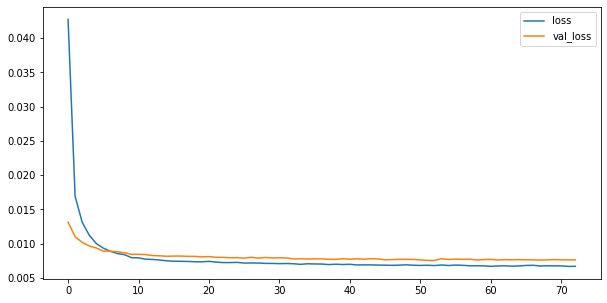

In [0]:
def build_model(X_train, y_train, X_test, y_test, n_steps_in, n_steps_out, epochs, verbose): 
  ## Build an LSTM model ##
    # Define model
    model = Sequential()
    model.add(LSTM(12, activation='relu', return_sequences= 1, input_shape=(n_steps_in, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences= 0))
    model.add(Dropout(0.5))
    #model.add(Dense(600))
    #model.add(Dense({{choice([120, 256, 512, 1024])}}))
    #model.add(LSTM(100, activation='relu', return_sequences= False))
    #model.add(Dropout(0.0001))
    #model.add(LSTM(100, activation='relu', return_sequences= False))
    #model.add(Dense(5))
    #model.add(LSTM(26, activation= 'relu'))
    #model.add(Dropout(0.01))
    model.add(Dense(n_steps_out)) 
    
    # Train Model
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, validation_split= 0.2, shuffle = False ,callbacks = [EarlyStopping(patience = 20)])
    
    # Visualise Epoch
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()

    return model, history

model, history = build_model(X_train, y_train, X_test, y_test, n_steps_in = n_steps_in, n_steps_out = n_steps_out, epochs = 100, verbose = 2)

In [0]:
def RMSE(model, X_test, y_test, n_steps_out, scaler):
  y_hat = scaler.inverse_transform(model.predict(X_test))
  RMSE = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(y_hat.shape[0], y_hat.shape[1])), y_hat, multioutput= 'raw_values'))
  mean_RMSE = sum(RMSE)/ n_steps_out  
  return y_hat, RMSE, mean_RMSE
y_hat_train, train_RMSE, train_mean_RMSE =RMSE(model, X_train, y_train, n_steps_out, s_demand)
y_hat,RMSE, mean_RMSE = RMSE(model, X_test, y_test, n_steps_out, s_demand)
print("Train")
print(train_RMSE, train_mean_RMSE)
print("Test")
print(RMSE, mean_RMSE)

Train
[16.22654272 20.36027247 22.84719477 24.71937818 26.25973971 27.52555457
 28.72636788 29.86899856 30.876188   31.72287261 32.43903434 33.10684402] 27.056582318679364
Test
[15.36893034 19.44456433 22.04521189 23.92632429 25.44162038 26.82412515
 28.1332642  29.44512381 30.59288479 31.48825997 32.17177304 32.68514152] 26.46393531000959
